**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1vpNRvLYFs9NddIiuMl3-HIpUBeOj8Up5?usp=sharing)

2. [Практический ноутбук 1](https://colab.research.google.com/drive/1fl5Cyd8Vf105Yqxvbq2_Z7cILyU4xl1r?usp=sharing)
3. Практический ноутбук 2


#Обработка текстов нейронными сетями: классификация обращений граждан

Привет! Это продолжение занятия по обработке текстов с помощью нейронных сетей. В
этой части вы на практике разберете обработку текста из табличных данных. В частности,
базу обращений граждан с различными жалобами, просьбами, пожеланиями в
определенные ведомства. Основной текст для обработки в этом случае – сами обращения.
Наряду с этим указана категория, к которой обращение относится, а также характер
самого обращения.

Вы попробуете применить здесь уже рассмотренные способы обработки текста: Bag Of
Words и Embedding. Задача состоит в том, чтобы создать нейронную сеть, которая по
тексту обращения гражданина сразу поймет, к какой категории это обращение относится.

##Импорт библиотек

Уже знакомым вам способом подключите для работы все необходимые инструменты:
библиотеки целиком, различные модули, функции, нейронные слои. А также загрузите
базу данных для ее обработки и дальнейшего обучения НС.

In [1]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Отрисовка графиков
import matplotlib.pyplot as plt

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Кодирование тестовых меток
from sklearn.preprocessing import LabelEncoder

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

##Загрузка датасета и подготовка данных

In [2]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/clean_data.csv', None, quiet=True)

'clean_data.csv'

Библиотека Pandas поможет прочесть данные в виде таблицы, чтобы работа с ними стала
удобнее.

Сохраните данные в переменную **df**.

Pandas инициирована как `pd`, а `read_csv()` – функция чтения данных табличного
формата.

In [3]:
# Загрузка данных из файла в таблицу
df = pd.read_csv('clean_data.csv')

Функция `shape()` сообщает, что в таблице 10 059 строк (самих обращений граждан) и 3
столбца, чтобы удобно упорядочить все данные по разделам.

In [4]:
# Вывод размерности таблицы
print(df.shape)

(10059, 3)


Деление данных по
столбцам, соответственно, это текст обращения, категория обращения и его
направленность (тематика). Это вы увидите, отобразив первые 5 строк базы с помощью
`head()`:

In [5]:
# Вывод первых строк таблицы
df.head()

,text,category,theme
0,Здравствуйте. Подскажите пожалуйста можно ли с...,Дороги и транспорт,Запрос на льготы / субсидии
1,Подскажите пожалуйста имеют ли право не платит...,ЖКХ,Запрос юридической консультации
2,""" Спасибо Вам огромное за возобновление строит...",Строительство,Запрос юридической консультации
3,Проблема одна и общая стала в городе. Спорт. у...,Спорт,Недовольство общее
4,Некоторое время назад для школьников и студент...,Дороги и транспорт,Запрос на льготы / субсидии


Функция `isnull()` считает все пустые места в таблице с данными, a `sum()` помогает
сложить их вместе.

Посмотрите краткую статистику по пропускам:

In [6]:
# Проверка, есть ли пропуски в данных
print(df.isnull().sum())

text           0
category    1797
theme       1824
dtype: int64


Пропуски можно заполнить одинаковым сообщением с помощью `fillna()`:

In [7]:
# Есть пропуски. Замена всех пустых значений на 'нет данных'
df.fillna('нет данных', inplace=True)

Чтобы посмотреть любое обращение, его категорию и тему, воспользуйтесь индексом
строки таблицы. Для этого используют `values [*здесь указать индекс строки*]`.

Вы уже не раз сталкивались со словом *value* то в одном контексте, то в другом. В
программировании его переводят как «значение». А в Pandas команда `values` дает
доступ к одной или сразу к ряду ячеек в таблицах данных.

In [8]:
# Пример данных из таблицы
print(df.values[0])

['Здравствуйте. Подскажите пожалуйста можно ли сделать проезд для школьников по льготной цене. Для людей работающих в бюджетной организации, с детьми на проезд уходит значительная часть денег на оплату проезда .'
 'Дороги и транспорт' 'Запрос на льготы / субсидии']


##Модель на наборе данных без балансировки и фильтрации

Если бы вы хотели получить наглядную информацию об объемах данных по каждой
категории, то написали бы для этого простую функцию, как в примере ниже.

Имя функции *data_summary* с английского переводится как «обобщенная информация о
данных». Внутри функции всего две строки кода:
1. С циклом `for`, который проходит по всем категориям обращений граждан (в
функции категории сохранены как **class_labels**, а ниже виден исходный
доступ к ним через `df.category`).
2. Форматированная строка с выводом информации по категориям, где:

    * **cls** – имя для каждой ячейки с названием категории;

    * `df[df.category == cls]` – доступ ко всему столбцу категорий целиком;

    * добавление `.shape[0]` в конце – доступ к ячейкам построчно, т.е. по
отдельности.

Протестируйте функцию и изучите информацию о количестве обращений по отдельно
взятой категории:

In [9]:
# Функция вывода сводки по распределению данных
def data_summary(df, class_labels):
    for cls in class_labels:
        print(f'Количество записей класса {cls}: {df[df.category == cls].shape[0]}')

Метод `unique()` для базы данных за вас подсчитывает количество обращений по каждой
категории. Укажите его при подаче в функцию.

Посмотрите на последнюю строку сводки. Согласно ей, в вашей таблице довольно
большое количество пустых ячеек. Там могли бы быть данные, а их общий объем зависит
от сложности сбора базы. Чаще всего это одна из самых важных и сложных задач
нейронщика до того, как приступить к созданию НС. В общедоступных таблицах вместо
данных часто будут пропуски. Ваша задача - знать, как решить такую проблему в своих
личных проектах.

In [10]:
# Сводка по распределению данных
data_summary(df, df.category.unique())

Количество записей класса Дороги и транспорт: 1411
Количество записей класса ЖКХ: 2063
Количество записей класса Строительство: 349
Количество записей класса Спорт: 246
Количество записей класса Благо­­устрой­­ство: 1686
Количество записей класса Образование и наука: 290
Количество записей класса Культура: 100
Количество записей класса Демография: 20
Количество записей класса Социальная сфера: 370
Количество записей класса Другое: 208
Количество записей класса Бизнес: 187
Количество записей класса Здравоохранение: 368
Количество записей класса Органы власти: 244
Количество записей класса Экология: 180
Количество записей класса Правопорядок: 172
Количество записей класса Труд и занятость населения: 151
Количество записей класса Борьба с коррупцией: 59
Количество записей класса Промышленность: 13
Количество записей класса Сельское хозяйство: 50
Количество записей класса Земельные отношения: 80
Количество записей класса Туризм: 15
Количество записей класса нет данных: 1797


###Преобразование текстовых данных в числовые и векторные представления для обучения нейросети

Код ниже знаком вам по первой части занятия.

Если все обращения граждан – это один строковый образец текста, то надо выделить часть
этого текста по частоте повторений слов. Это и делает токенизатор в Keras.
1. Выделите лимит в 30 000 слов, сохраните его в **VOCAB_SIZE**.
2. `TRAIN_TEST_RATIO = 0.2` буквально означает, что на проверку точности НС
будет выделено 20% от обучающих примеров.

Учитывайте, что и **VOCAB_SIZE**, и **TRAIN_TEST_RATIO** – это просто имена
переменных, придуманные для удобства.

In [11]:
# Задание параметров преобразования
VOCAB_SIZE       = 30000                  # Объем словаря для токенизатора
TRAIN_TEST_RATIO = 0.2                    # Доля проверочной выборки в основном наборе

**Токенизация и преобразование в последовательности**

В этой части вы поработаете с данными в табличном формате, но окончательный вид
данных для обработки – текст. Со временем вы научитесь замечать, к какому типу
принадлежат данные. При обработке текста сначала объединяют весь набор
тренировочных данных в один неразрывный текст.

Сохраните обобщенный текст всех обращений граждан в переменной **text_data**.
Команда `df.text` сразу предоставит доступ ко всему столбцу с обращениями. А
`tolist()` позволит получить списки обращений, собранные в одно целое.

Тот же набор действий используют для переменной **class_data**, но здесь идет работа
уже с категориями обращений граждан. Обучаясь на этих данных, НС узнает, как
правильно сопоставить обращение с его категорией и точно определить ответ. Здесь вы
получите доступ к столбцу категорий `df.category`, и так же сохраните их все в список
`tolist()`.

In [12]:
# Извлечение всех записей-текстов обращений и их меток классов
text_data = df.text.tolist()
class_data = df.category.tolist()

Уже известный вам Tokenizer составит на основе текста обращений граждан словарь
частотности с ограничением до индекса 30 000 (значение **VOCAB_SIZE**). Тогда каждое
слово получит свой индекс в зависимости от частоты его повторений, а до этого из текста
будут убраны все символы, все заглавные буквы станут строчными и будут разделены
лишь пробелами. Как вы уже знаете, все слова, не попавшие в диапазон **VOCAB_SIZE**
будут признаны неизвестными словами и получат такое же название и индекс 1.

Сам словарь формируется для токенайзера функцией `fit_on_texts()`.

Функция `word_index_items()` поможет образовать тот же словарь в виде пар «слово :
индекс частоты повторений слова».

In [13]:
# Токенизация и построение частотного словаря по обучающим текстам
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

# Использованы параметры:
# num_words   - объем словаря
# filters     - убираемые из текста ненужные символы
# lower       - приведение слов к нижнему регистру
# split       - разделитель слов
# char_level  - указание разделять по словам, а не по единичным символам
# oov_token   - токен для слов, которые не вошли в словарь

# Построение частотного словаря по обучающим текстам
tokenizer.fit_on_texts(text_data)

# Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())

В библиотеке Sklearn есть очень полезный инструмент *LabelEncoder*. Его используют в
тех случаях, когда работают с категориальными данными. В вашей таблице есть
множество категорий обращений граждан, к примеру «Спорт», «ЖКХ» или
«Строительство». Ваша НС будет выявлять принадлежность обращения гражданина к
одной из таких категорий.

*LabelEncoder* преобразует весь список категорий текстового типа (`class_data`) в список
индексов от 0 и до последней категории по счету. Если какая-либо категория встречается
повторно, то она все равно сохраняет тот индекс, что первоначально ей присвоен. Так,
сколько раз вы бы не встретили категорию «Спорт», если ее индекс 3, то он так и
останется 3.

Всего категорий (или классов) получилось 22. Это значение сохранено в переменной
**CLASS_COUNT**:


Обратите внимание на вывод статистики ниже. Размер словаря превышает лимит в 30 000,
что нормально, поскольку лимит задан для частоты повторений, а не для общего

количества слов. Например союз «и» может иметь индекс 2, но встречаться очень большое
количество раз.

Еще заметен очень странный вид названия класса «Благоустройство». Иногда сама
кодировка текста может слегка сбиться таким вот образом, но на работе НС это никак не
сказывается.

---
Дополнительная информация ([База знаний УИИ - «**LabelEncoder**»](https://colab.research.google.com/drive/1oslkPxYduzt7ZPFEFTaknyqOWZdhPqLx?usp=sharing))

---

In [14]:
# Кодирование меток классов индексами (числами)
encoder = LabelEncoder()
class_labels = encoder.fit_transform(class_data)

CLASS_LIST = encoder.classes_
CLASS_COUNT = len(CLASS_LIST)

print(f'Размер словаря: {len(items)}')
print(f'Список классов: {CLASS_LIST}')
print(f'Всего классов: {CLASS_COUNT}')
print(f'Форма выходных данных: {class_labels.shape}')
print(f'Пример числовых меток классов: {class_labels[:10]}')

Размер словаря: 80591
Список классов: ['Бизнес' 'Благо\xad\xadустрой\xad\xadство' 'Борьба с коррупцией'
 'Демография' 'Дороги и транспорт' 'Другое' 'ЖКХ' 'Здравоохранение'
 'Земельные отношения' 'Культура' 'Образование и наука' 'Органы власти'
 'Правопорядок' 'Промышленность' 'Сельское хозяйство' 'Социальная сфера'
 'Спорт' 'Строительство' 'Труд и занятость населения' 'Туризм' 'Экология'
 'нет данных']
Всего классов: 22
Форма выходных данных: (10059,)
Пример числовых меток классов: [ 4  6 17 16  4  4  4  4  1  4]


Словарь частотности повторений уже составлен.

Используйте функцию токенайзера `texts_to_sequences()` и получите текст для
обучения в виде одних только индексов (чисел).

Переменная **x_data** задана для подготовки данных к самому обучению, потому же
данные внутри нее сразу преобразуются в numpy-массив через `np.array()`:

Будет здорово, если вы освоите материал занятия и выполните такие же задачи
самостоятельно! Пусть это будет вашей мотивацией.

В блоке кода ниже текст обращений также преобразуется в матрицу
(`texts_to_matrix`) из значений 0 и 1 для изученного ранее способа *Bag Of Words*. Эти
данные сохраняются в переменной **x_data_01**.

Вы помните, что верные ответы (категории обращений) были переведены *LabelEncoder* в
формат индексов. Но нейронные сети хорошо работают именно с нормализованными
данными. Формат от 0 до 1 – лучшая нормализация. Однако и ряд индексов категорий –
это не полноценный текст, а просто слова и словосочетания (метки классов). Для
преобразования категорий ответов для подачи в сеть чаще всего используют метод
`utils.to_categorical`. Он дает вектор из нулей и одной единицы (положение
верного ответа) для каждой категории в отдельности.

In [15]:
# Преобразование входных текстов в последовательности индексов (для архитектур с embedding)
# Применено приведение к массиву объектов для дальнейшего разделения на выборки
x_data = np.array(tokenizer.texts_to_sequences(text_data), dtype=object)
# Вывод формы и примера данных
print(x_data.shape)
print(x_data[0][:20])

# Преобразование входных текстов в разреженную матрицу из векторов Bag of Words
x_data_01 = tokenizer.texts_to_matrix(text_data)
# Вывод формы и примера данных
print(x_data_01.shape)
print(x_data_01[0, :20])

# Преобразование меток класса к векторам one hot encoding
y_data = utils.to_categorical(class_labels, CLASS_COUNT)
# Вывод формы и примера данных
print(y_data.shape)
print(y_data[0])

(10059,)
[50, 1821, 113, 83, 188, 166, 506, 15, 1636, 7, 7317, 4694, 15, 176, 4438, 2, 5632, 283, 6, 289]
(10059, 30000)
[0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(10059, 22)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


**Создание обучающей и тестовой выборок**

На данный момент вы располагаете **x_data** – общим массивом чисел для обучения.

Этот массив необходимо поделить на обучающую выборку и тестовую, ведь вы хотите
тестировать точность сети на независимых данных! Метод `train_test_split()`
поможет провести границу деления, результат которого для границы обучающей выборки
сохраняют переменные **idx_train** и **idx_test** – для тестовой.

В параметрах метода:
1. `range(len( ))` для **x_data** – диапазон длины всего массива для обучения.
2. `stratify = y_data` – сопоставление тренировочных и тестовых данных с
ответами к ним.

3. `test_size = TRAIN_TEST_RATIO` – то самое значение деления
(`TRAIN_TEST_RATIO = 0.2`) общего массива на 80% (тренировочная выборка) к
20% (тестовая выборка).

Поместите **idx_train**, **idx_test** в диапазон **x_data** (`x_data[idx_train],
x_data[idx_test]`). Так вы получите уже финальные выборки. Их можно подать на
обучение сети. То же самое сделайте для **x_data_01**, чтобы получить выборки для
способа *Bag Of Words*.

В конце важно проверить размерности каждой выборки, чтобы правильно задать
гиперпараметры обучения НС. Это можно сделать с помощью `shape()`

In [16]:
# Получение индексов разделения основного набора на обучающую и тестовую выборки
idx_train, idx_test = train_test_split(list(range(len(x_data))),
                                       stratify=y_data,
                                       test_size=TRAIN_TEST_RATIO)

# Разделение в соответствии с полученными индексами
x_train, x_test = x_data[idx_train], x_data[idx_test]
x_train_01, x_test_01 = x_data_01[idx_train], x_data_01[idx_test]
y_train, y_test = y_data[idx_train], y_data[idx_test]

# Проверка результата
print(x_train.shape, x_test.shape)
print(x_train_01.shape, x_test_01.shape)
print(y_train.shape, y_test.shape)

(8047,) (2012,)
(8047, 30000) (2012, 30000)
(8047, 22) (2012, 22)


###Сервисные функции


Данные функции взяты из предыдущего ноутбука по классификации текстов писателей.
Эти функции собирают параметры обучения модели воедино (компиляция), оценивают
точность уже обученной сети и выводят графики процесса обучения и точности. Две
первые функции последовательно вызываются в третьей –
`compile_train_eval_model()`. Именно ей вы и воспользуетесь.

In [17]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

### BagOfWords + Dense

Первая модель в этой части занятия все та же – полносвязная НС с применением *Bag Of
Words*. Исходя из этого, имя модели **model_text_bow_dense** состоит из 7 слоев, из
которых 4 слоя – полносвязные (Dense).

Внимание! Закрепите правильную подачу размера выборки на входном слое НС (параметр
**input_dim**). Размеры выборок для *Bag Of Words* **x_train_01** и **x_test_01** – это 8047
х 30 000 и 2012 х 30 000 соответственно. Здесь 30 000 – параметр размера созданного вами
словаря частотности. Другими словами – количество значений, которое сеть должна
получить на вход. Значение было сохранено в переменной **VOCAB_SIZE**.

Каждый Dense-слой сети включает по 100 нейронов и функцию активации `relu`. Кроме
слоя выхода там должно получиться число нейронов в соответствии с количеством
определяющихся категорий (22, это число сохранено в **CLASS_COUNT**). Функция
активации тоже отлична (здесь `softmax`).

Скомпилируйте, обучите модель и посмотрите на результат.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │     3,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         2,222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,022,522 (11.53 MB)

 Trainable params: 3,022,522 (11.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.2529 - loss: 2.4568 - val_accuracy: 0.4548 - val_loss: 1.7689
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4921 - loss: 1.6188 - val_accuracy: 0.5224 - val_loss: 1.6194
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6399 - loss: 1.1791 - val_accuracy: 0.5383 - val_loss: 1.6111
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7301 - loss: 0.9097 - val_accuracy: 0.5398 - val_loss: 1.6642
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7808 - loss: 0.7422 - val_accuracy: 0.5467 - val_loss: 1.8195
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8255 - loss: 0.6023 - val_accuracy: 0.5427 - val_loss: 1.9687
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8497 - loss: 0.5386 - val_accuracy: 0.5353 - val_loss: 1.9657
Epoch 8/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8603 - loss: 0.5039 - val_accuracy: 

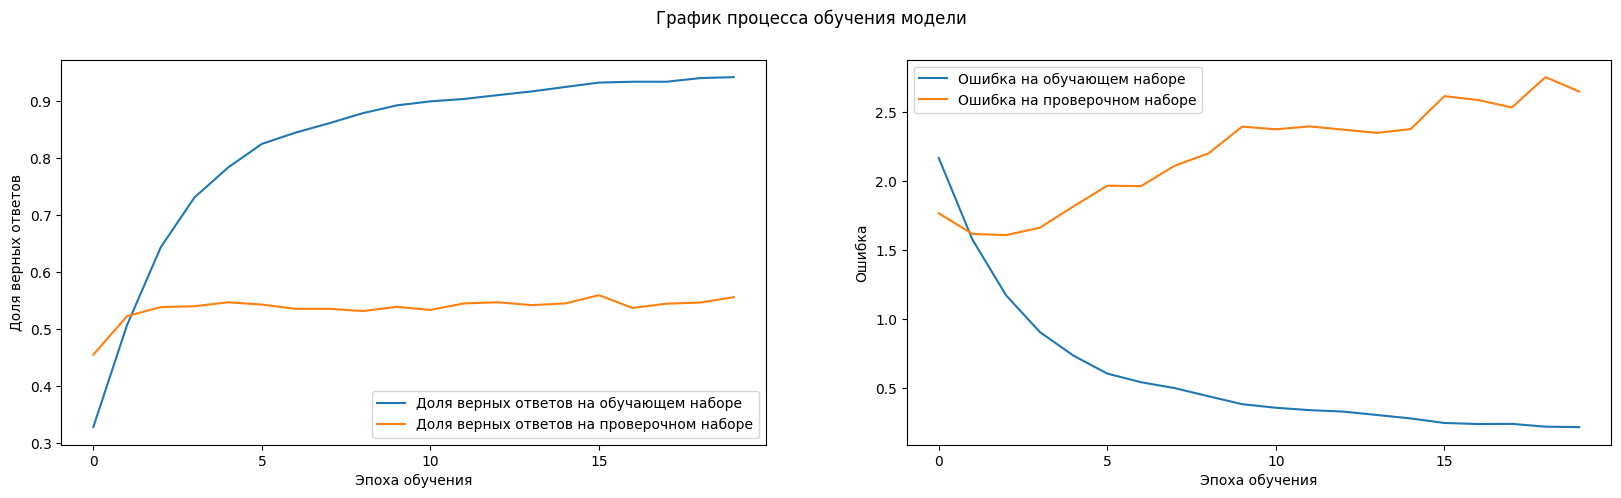

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


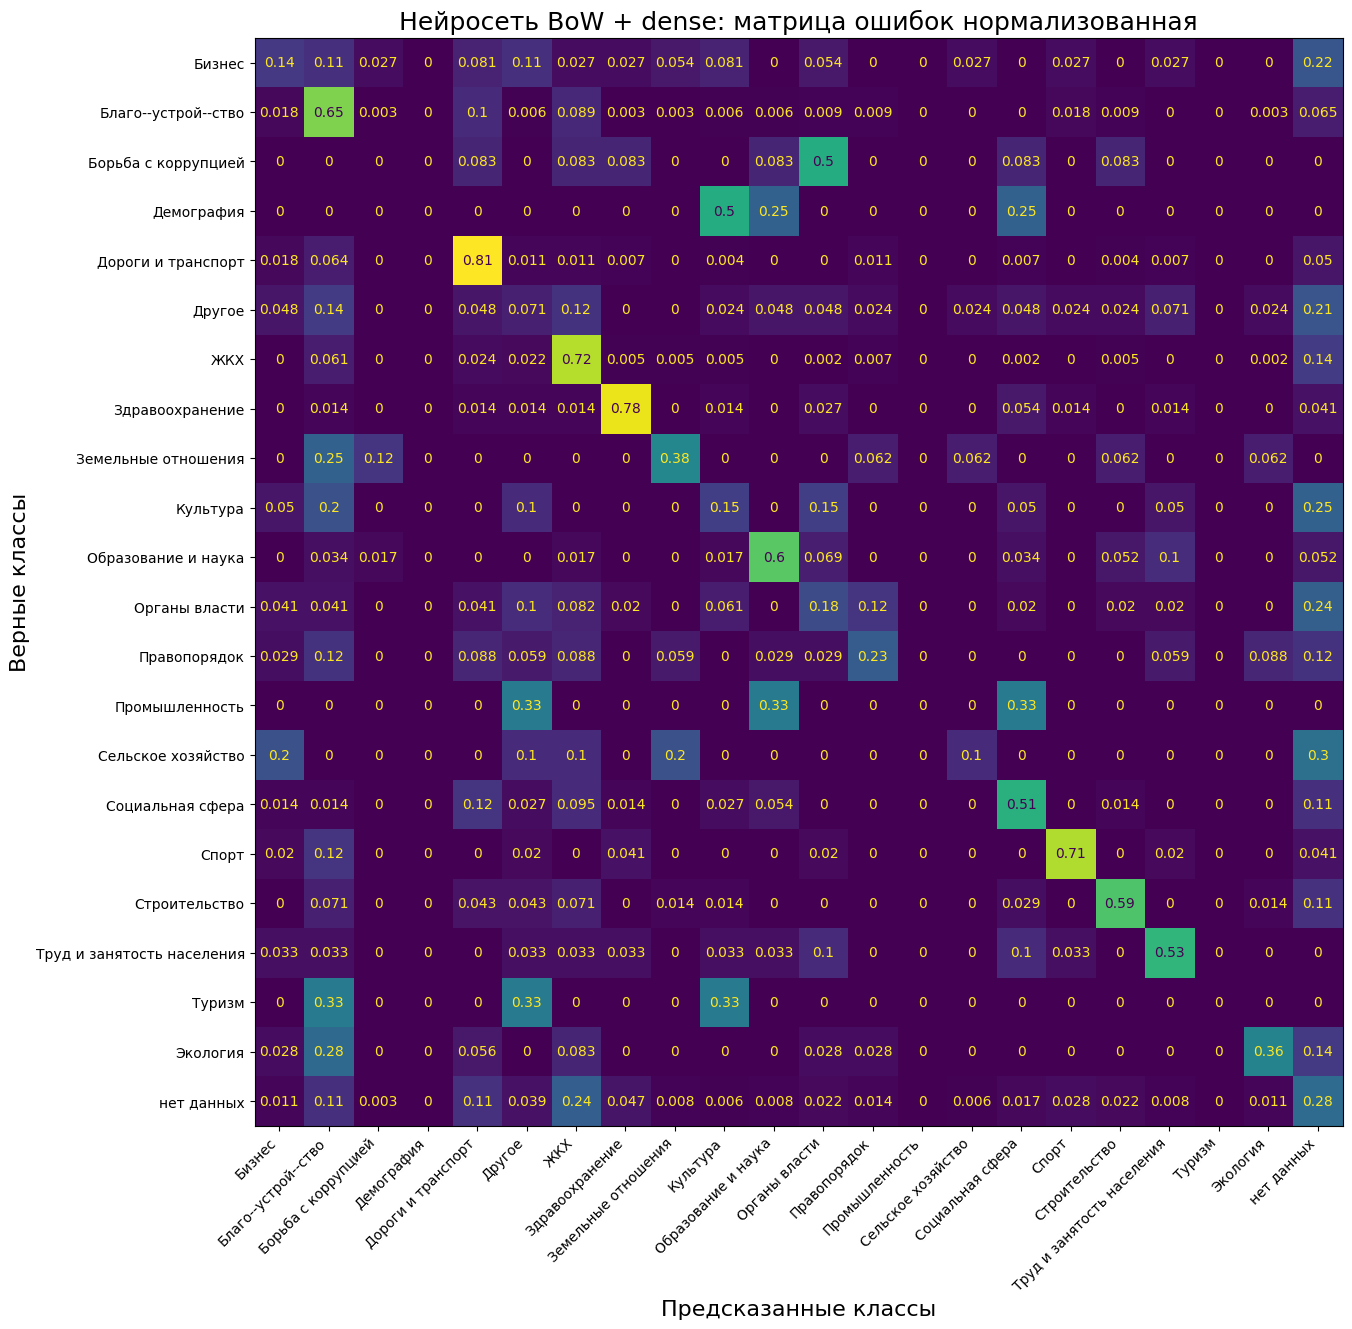

----------------------------------------------------------------------------------------------------
Нейросеть: BoW + dense
Класс: Бизнес                22% сеть отнесла к классу нет данных           - НЕВЕРНО :-(
Класс: Благо­­устрой­­ство   65% сеть отнесла к классу Благо­­устрой­­ство  - ВЕРНО :-)
Класс: Борьба с коррупцией   50% сеть отнесла к классу Органы власти        - НЕВЕРНО :-(
Класс: Демография            50% сеть отнесла к классу Культура             - НЕВЕРНО :-(
Класс: Дороги и транспорт    81% сеть отнесла к классу Дороги и транспорт   - ВЕРНО :-)
Класс: Другое                21% сеть отнесла к классу нет данных           - НЕВЕРНО :-(
Класс: ЖКХ                   72% сеть отнесла к классу ЖКХ                  - ВЕРНО :-)
Класс: Здравоохранение       78% сеть отнесла к классу Здравоохранение      - ВЕРНО :-)
Класс: Земельные отношения   38% сеть отнесла к классу Земельные отношения  - ВЕРНО :-)
Класс: Культура              25% сеть отнесла к классу нет данных           

In [18]:
# Последовательная модель
model_text_bow_dense = Sequential()
# Входной полносвязный слой
model_text_bow_dense.add(Dense(100, input_dim=VOCAB_SIZE, activation="relu"))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Второй полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Третий полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Выходной полносвязный слой
model_text_bow_dense.add(Dense(CLASS_COUNT, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_dense,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         epochs=20,
                         batch_size=32,
                         cm_size=(16, 16),
                         class_labels=CLASS_LIST,
                         title='BoW + dense')

**Выводы по обучению модели BagOfWords + Dense**

1. На обучающей выборке процесс шел довольно уверенно: росла точность и падала
ошибка сети. Увы, но наиболее важный для оценки проверочный набор данных не
показал того же. Точность оставалась почти на одном уровне, а ошибка росла.
2. График-матрица ошибок показал, что НС неплохо научилась предсказывать
категории «Благоустройство» и «Спорт», а лучше всего – «Дороги и транспорт»,
«ЖКХ» и «Здравоохранение».
3. Средняя точность работы сети – 36% (оценка «неудовлетворительнo»).

Итак, в способе ли заключается проблема? Дело в *Bag Of Words* или, может, в плохой
архитектуре сети? Здесь, вероятно, переобучение НС, но основная проблема –
разбалансировка базы. Для получения высокой точности НС база примеров всегда должна
быть сбалансированной (как говорится, well-balanced).

По сводке статистики вы можете наблюдать, что некоторые категории содержат большое
количество примеров, а иные – невероятно малое. Сбалансировать базу можно двумя
путями:
1. Добавить недостающее число примеров для каждой категории.
2. Согласиться на снижение потенциала предсказания категорий сетью и оставить
только те, что будут соответствовать тому или иному усредненному значению для
базы.

Если способ обработки текста *Embedding* не сработает, то вы сможете воспользоваться
вторым подходом балансировки данных. Первый, увы, требует куда больших затрат
времени.

А пока ознакомьтесь со второй экспериментальной моделью полносвязной сети – уже с
Embedding-слоем!

### Embedding + Dense

Библиотека matplotlib помогает в визуальной оценке данных. На графике-гистограмме
ниже вы можете увидеть, что наибольшее количество обучающих примеров
сконцентрировано в промежутке от 0 (данные отсутствуют) до 200. Окончательно же
концентрация примеров спадает от 400 к 600. Это значит, что примеров обращений
объемом выше 600 в тренировочных данных очень мало, а больше всего либо пустых
примеров («нет данных»), либо тех, объем которых в районе 100 значений в примере.
График ниже – хороший пример разбалансированной базы.

Вложенный цикл `for` здесь – способ создать необходимые значения координат для
гистограммы. Они сохранены в **seq_list** (по ним получается кол-во столбцов графика и
их высота). Далее строится сам график с помощью `plt.hist()`, где в параметрах число
50 – число столбцов на всем графике.

Буквально `[len(x) for x in x_data]` расшифровывается так: вычислить размер каждого элемента (`len(x)`) для (`for`) каждого элемента (`х`) во
всем наборе данных (`x_data`).

И все это сразу сохраняется в список – [ ].

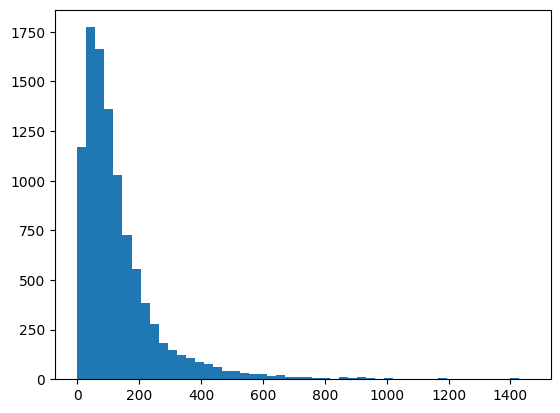

In [19]:
# Построение гистограммы распределения длин текстов основного набора
seq_len = [len(x) for x in x_data]
plt.hist(seq_len, 50)
plt.show()

В коде ниже предложен следующий подход: ограничить размер каждого примера. В
данном случае до 400 слов. Остальное в каждом примере будет просто отброшено.
Сохраните это значение в **seq_max_len**. Создайте переменные **x_train_clip** и
**x_test_clip** для выборок и укоротите длину примеров в них с помощью
`pad_sequences()`. Функция `pad_sequences()` не только обрезает примеры, но и дополняет их до нужного размера, если они короче. В результате вместо размерностей 8047 х 30 000 и 2012 х 30 000 вы
получите 8047 х 400 и 2012 х 400 для каждой выборки.

In [20]:
# Снижение размерности входных данных:
# ограничение длины последовательностей до разумного предела
seq_max_len = 400
x_train_clip = pad_sequences(x_train, maxlen=seq_max_len)
x_test_clip = pad_sequences(x_test, maxlen=seq_max_len)

# Проверка формы результата
print(x_train_clip.shape, x_test_clip.shape)

(8047, 400) (2012, 400)


А вот и архитектура вашей модели для *Embedding*. Она включает один входной слой
Embedding, два Dense-слоя для полносвязной обработки значений и несколько слоев
регуляризации и нормализации.

Обратите внимание на дополнительный гиперпараметр слоя Embedding **input_length**,
равный **seq_max_len**, т.е. значению 400. Этот параметр позволяет слою принять для
обработки данные из выборок **x_train_clip** и **x_test_clip**.

Выполните компиляцию модели и запустите обучение:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1052 - loss: 3.3083 - val_accuracy: 0.2947 - val_loss: 2.5982
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4902 - loss: 1.7539 - val_accuracy: 0.4011 - val_loss: 2.0233
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8251 - loss: 0.6885 - val_accuracy: 0.4259 - val_loss: 1.9337
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9441 - loss: 0.2834 - val_accuracy: 0.4230 - val_loss: 2.0014
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9734 - loss: 0.1483 - val_accuracy: 0.4145 - val_loss: 2.2102
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9828 - loss: 0.0979 - val_accuracy: 0.4190 - val_loss: 2.2047
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9857 - loss: 0.0795 - val_accuracy: 0.4051 - val_loss: 2.1896
Epoch 8/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9870 - loss: 0.0596 - val_accuracy: 0

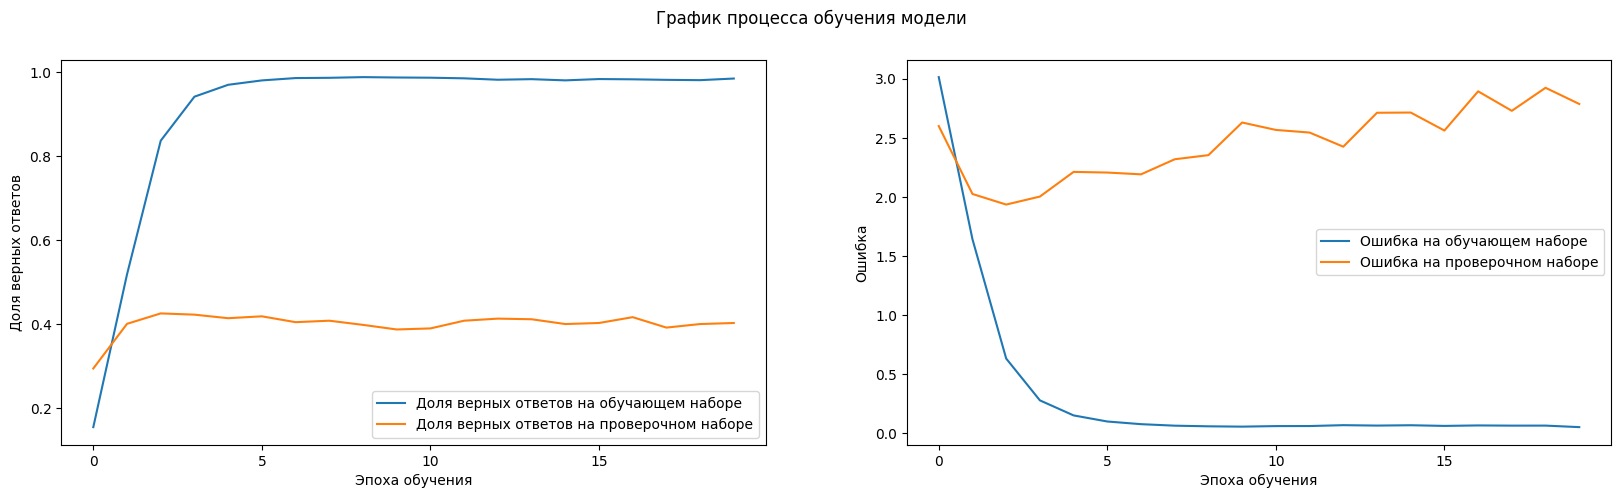

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


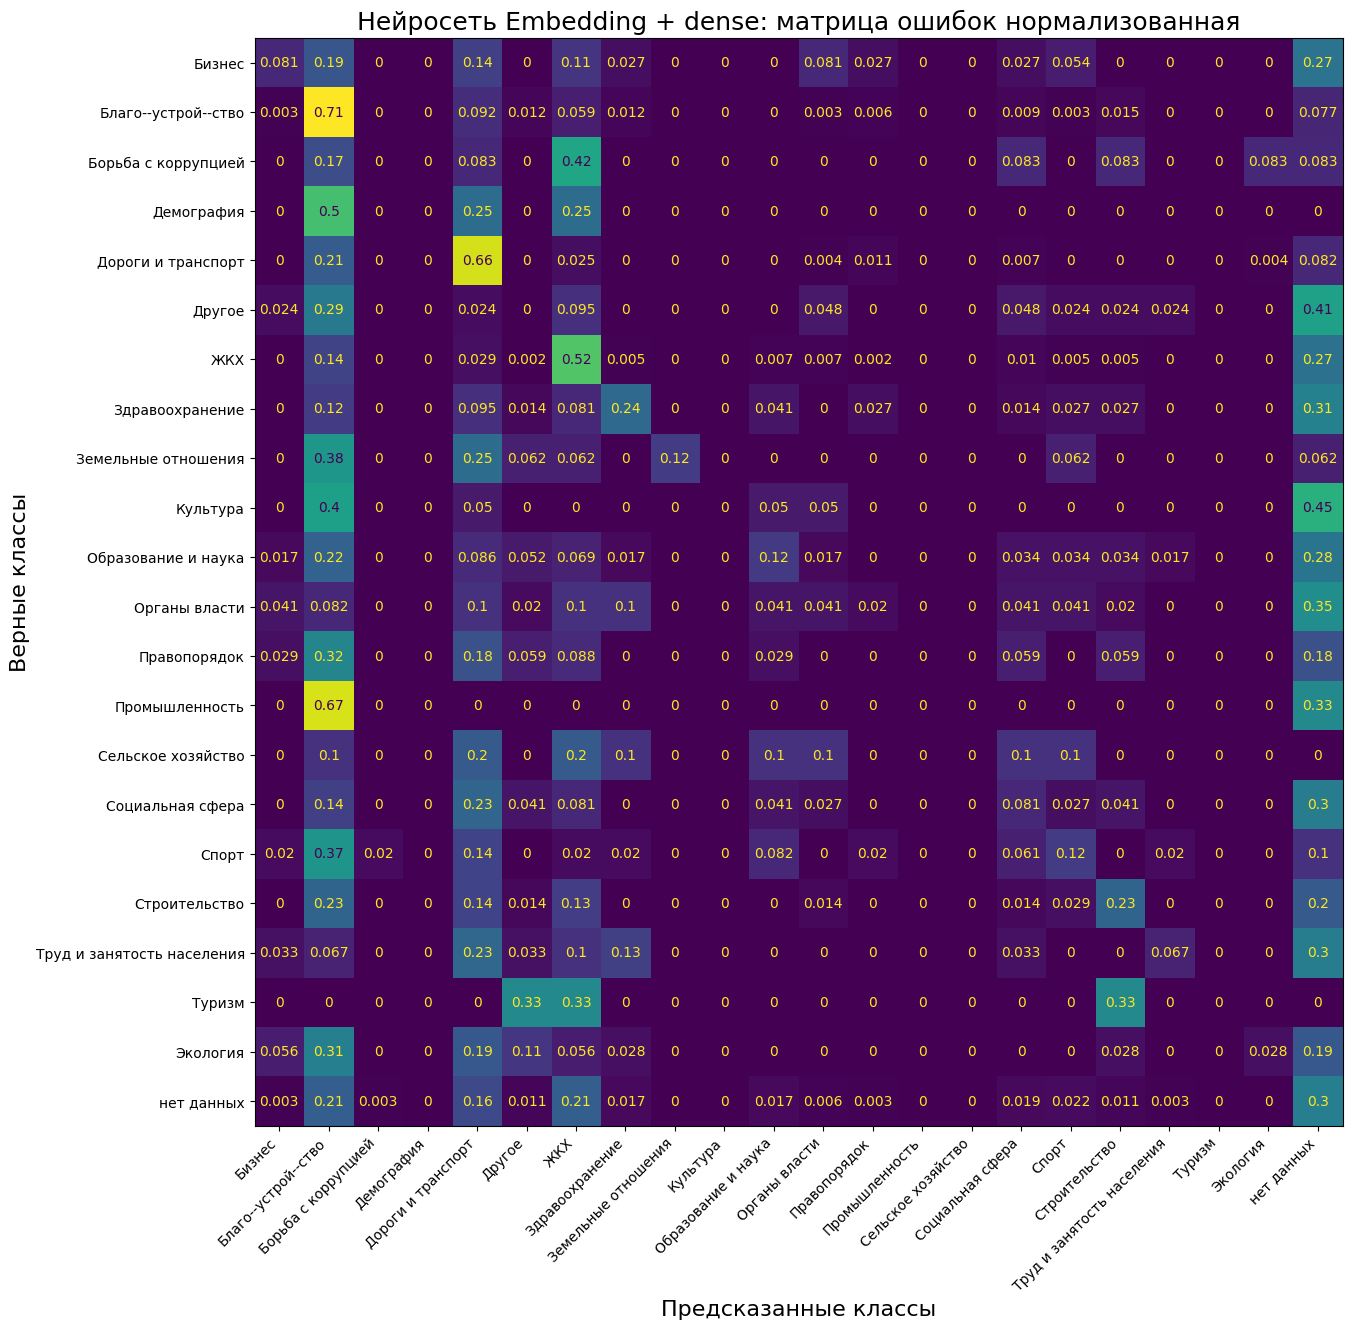

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding + dense
Класс: Бизнес                27% сеть отнесла к классу нет данных           - НЕВЕРНО :-(
Класс: Благо­­устрой­­ство   71% сеть отнесла к классу Благо­­устрой­­ство  - ВЕРНО :-)
Класс: Борьба с коррупцией   42% сеть отнесла к классу ЖКХ                  - НЕВЕРНО :-(
Класс: Демография            50% сеть отнесла к классу Благо­­устрой­­ство  - НЕВЕРНО :-(
Класс: Дороги и транспорт    66% сеть отнесла к классу Дороги и транспорт   - ВЕРНО :-)
Класс: Другое                40% сеть отнесла к классу нет данных           - НЕВЕРНО :-(
Класс: ЖКХ                   52% сеть отнесла к классу ЖКХ                  - ВЕРНО :-)
Класс: Здравоохранение       31% сеть отнесла к классу нет данных           - НЕВЕРНО :-(
Класс: Земельные отношения   38% сеть отнесла к классу Благо­­устрой­­ство  - НЕВЕРНО :-(
Класс: Культура              45% сеть отнесла к классу нет данных 

In [21]:
# Последовательная модель
model_text_emb_dense = Sequential()
# Cлой эмбеддингов
model_text_emb_dense.add(Embedding(VOCAB_SIZE, 50, input_length=seq_max_len))
# Слой регуляризации Dropout
model_text_emb_dense.add(SpatialDropout1D(0.2))
# Cлой преобразования многомерных данных в одномерные
model_text_emb_dense.add(Flatten())
# Слой пакетной нормализации
model_text_emb_dense.add(BatchNormalization())
# Полносвязный слой
model_text_emb_dense.add(Dense(64, activation="relu"))
# Слой регуляризации Dropout
model_text_emb_dense.add(Dropout(0.2))
# Слой пакетной нормализации
model_text_emb_dense.add(BatchNormalization())
# Выходной полносвязный слой
model_text_emb_dense.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_text_emb_dense,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         epochs=20,
                         batch_size=32,
                         cm_size=(16, 16),
                         class_labels=CLASS_LIST,
                         title='Embedding + dense')

**Выводы по обучению модели Embedding + Dense**

1. Процесс обучения похож на первую модель: точность на обучающей выборке
росла и падала ошибка сети. Однако проверочный набор вновь говорил о проблеме
– точность почти неизменна, ошибка росла.
2. График-матрица ошибок показал, что НС неплохо научилась предсказывать
категории «Дороги и транспорт» и «ЖКХ», но не более.
3. Средняя точность работы сети – 15%, что хуже модели с *Bag Of Words* (оценка –
«неудовлетворительно»).

Вы снова проделали нелегкую работу! Финальный рывок – проверить точность сети при
обучении на сбалансированной выборке.

##Модель на отфильтрованном и сбалансированном наборе данных

---



###Фильтрация и балансировка данных

Сперва взгляните на статистику по категориям вашей базы данных.

В этом вам поможет
первоначальная функция `data_summary()`:

In [22]:
# Сводка по распределению данных в порядке кодированных меток
data_summary(df, CLASS_LIST)

Количество записей класса Бизнес: 187
Количество записей класса Благо­­устрой­­ство: 1686
Количество записей класса Борьба с коррупцией: 59
Количество записей класса Демография: 20
Количество записей класса Дороги и транспорт: 1411
Количество записей класса Другое: 208
Количество записей класса ЖКХ: 2063
Количество записей класса Здравоохранение: 368
Количество записей класса Земельные отношения: 80
Количество записей класса Культура: 100
Количество записей класса Образование и наука: 290
Количество записей класса Органы власти: 244
Количество записей класса Правопорядок: 172
Количество записей класса Промышленность: 13
Количество записей класса Сельское хозяйство: 50
Количество записей класса Социальная сфера: 370
Количество записей класса Спорт: 246
Количество записей класса Строительство: 349
Количество записей класса Труд и занятость населения: 151
Количество записей класса Туризм: 15
Количество записей класса Экология: 180
Количество записей класса нет данных: 1797


C помощью matplotlib постройте гистограмму объема данных по каждой категории. По
нему вы сможете визуально сравнить количество обращений граждан по каждой
категории:

Лидируют по объему – «Благоустройство», «ЖКХ», «Дороги и транспорт» и «нет данных»
(пустые ячейки). Еще 9-10 категорий показали средний объем данных. Итог: около 8
категорий имеют недостаточный объем данных для точности обучения. Учитывайте, что
это посчитано, исходя из общего количества категорий – 22.

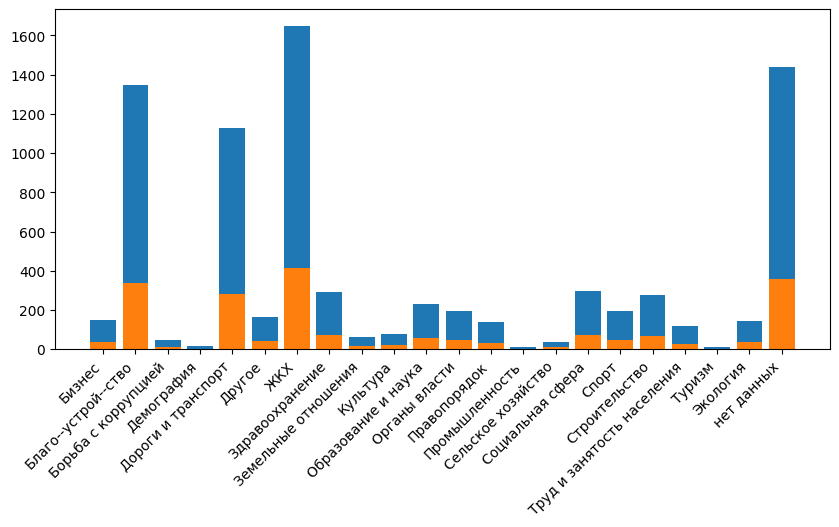

In [23]:
# Проверка сбалансированности выборок по классам
fig = plt.figure(figsize=(10, 5))
c_train = np.bincount(np.argmax(y_train, axis=1))
c_test = np.bincount(np.argmax(y_test, axis=1))
plt.bar(CLASS_LIST, c_train)
plt.bar(CLASS_LIST, c_test)
fig.autofmt_xdate(rotation=45)
plt.show()

Задав определенный интервал для числа обращений на категорию, вы сможете отсечь
категории со слишком малым количеством примеров. Для этого, основываясь на графике,
установите нижний порог интервала в 200 обращений:

Все верно, но точность сети по-прежнему будут определять самые большие категории.
Соответственно, ими тоже нужно пожертвовать, верно? Правда, здесь вам не обязательно
их удалять, можно просто сократить их объем.

Для фильтрации начальной базы сделайте следующее:
1. В **text_count_interval** поместите интервал для объема категорий, которые
допустимо оставить для должного обучения – от 200 до 400 обращений.
2. Список удаленных категорий сохраните в **class_to_drop**, куда по умолчанию
сразу добавьте категорию «нет данных».
3. Циклом **for** пройдитесь по всем категориям базы, добавьте в условие `if <
text_count_interval[0]`, пополнив список категорий на удаление (здесь
индекс [0] обращен к нижнему порогу интервала = 200).
4. Через `isin()` проверьте все категории на наличие категорий из списка на
удаление. Найденные соответствия сохраните в **del_mask**. И посредством
символа тильда "~", который выполняет роль отрицания в индексе, перезапишите
исходную базу, тем самым удалив лишние категории.
5. Последним циклом `for` в блоке вы просто урежете большие категории до верхнего
порога интервала (`text_count_interval[1]`, равный 400) через функцию
`drop`.

In [24]:
# Назначение интервала допустимого количества текстов по классу
text_count_interval = [200, 400]

# Фильтрация данных - отбрасываются все данные без категории
# и все классы объемом менее нижней границы разрешенного интервала
class_to_drop = ['нет данных']
for cls in df.category.unique():
    if df[df.category == cls].shape[0] < text_count_interval[0]:
        class_to_drop.append(cls)

print(f'Удаляются классы: {class_to_drop}')

del_mask = df.category.isin(class_to_drop)
df = df[~del_mask]

# По всем оставшимся классам количество примеров ограничивается не более
# верхней границы разрешенного интервала
for cls in df.category.unique():
    df = df.drop(df[df.category == cls].index[text_count_interval[1]:])

Удаляются классы: ['нет данных', 'Культура', 'Демография', 'Бизнес', 'Экология', 'Правопорядок', 'Труд и занятость населения', 'Борьба с коррупцией', 'Промышленность', 'Сельское хозяйство', 'Земельные отношения', 'Туризм']


Сравните получившуюся базу с исходной! Другое дело, ведь сейчас вы можете
рассчитывать на большую точность работы НС, хотя и пожертвовали для этого рядом
категорий.

In [25]:
data_summary(df, df.category.unique())

Количество записей класса Дороги и транспорт: 400
Количество записей класса ЖКХ: 400
Количество записей класса Строительство: 349
Количество записей класса Спорт: 246
Количество записей класса Благо­­устрой­­ство: 400
Количество записей класса Образование и наука: 290
Количество записей класса Социальная сфера: 370
Количество записей класса Другое: 208
Количество записей класса Здравоохранение: 368
Количество записей класса Органы власти: 244


**Токенизация и преобразование в последовательности**

Блоки кода ниже повторяют уже рассмотренные вами операции по предобработке данных,
только теперь вы работаете с новой сбалансированной базой:

In [26]:
# Извелечение всех записей-текстов обращений и их меток классов
text_data = df.text.tolist()
class_data = df.category.tolist()

In [27]:
# Токенизация и построение частотного словаря по обучающим текстам
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

# Использованы параметры:
# num_words   - объем словаря
# filters     - убираемые из текста ненужные символы
# lower       - приведение слов к нижнему регистру
# split       - разделитель слов
# char_level  - указание разделять по словам, а не по единичным символам
# oov_token   - токен для слов, которые не вошли в словарь

# Построение частотного словаря по обучающим текстам
tokenizer.fit_on_texts(text_data)

# Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())

In [28]:
# Кодирование меток классов индексами (числами)
encoder = LabelEncoder()
class_labels = encoder.fit_transform(class_data)

CLASS_LIST = encoder.classes_
CLASS_COUNT = len(CLASS_LIST)

print(f'Размер словаря: {len(items)}')
print(f'Список классов: {CLASS_LIST}')
print(f'Всего классов: {CLASS_COUNT}')
print(f'Форма выходных данных: {class_labels.shape}')
print(f'Пример числовых меток классов: {class_labels[:10]}')

Размер словаря: 47299
Список классов: ['Благо\xad\xadустрой\xad\xadство' 'Дороги и транспорт' 'Другое' 'ЖКХ'
 'Здравоохранение' 'Образование и наука' 'Органы власти'
 'Социальная сфера' 'Спорт' 'Строительство']
Всего классов: 10
Форма выходных данных: (3275,)
Пример числовых меток классов: [1 3 9 8 1 1 1 1 0 1]


В статистике, приведенной выше, еще раз взгляните на количество оставшихся классов
(категорий). Теперь их 10.

Далее все действия по обработке и подготовке данных в точности повторяются с
использованными ранее. Для ускорения процесса можете даже просто скопировать
предыдущие блоки, ведь все имена переменных и операции совпадают.

In [29]:
# Преобразование входных текстов в последовательности индексов (для архитектур с embedding)
# Применено приведение к массиву объектов для дальнейшего разделения на выборки
x_data = np.array(tokenizer.texts_to_sequences(text_data), dtype=object)
# Вывод формы и примера данных
print(x_data.shape)
print(x_data[0][:20])

# Преобразование входных текстов в разреженную матрицу из векторов Bag of Words
x_data_01 = tokenizer.texts_to_matrix(text_data)
# Вывод формы и примера данных
print(x_data_01.shape)
print(x_data_01[0, :20])

# Преобразование меток класса к векторам one hot encoding
y_data = utils.to_categorical(class_labels, CLASS_COUNT)
# Вывод формы и примера данных
print(y_data.shape)
print(y_data[0])

(3275,)
[59, 1911, 115, 82, 168, 166, 414, 15, 1034, 7, 4170, 6926, 15, 161, 4816, 2, 3297, 281, 6, 261]
(3275, 30000)
[0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3275, 10)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


**Создание обучающей и проверочной выборки**

In [30]:
# Получение индексов разделения основного набора на обучающую и тестовую выборки
idx_train, idx_test = train_test_split(list(range(len(x_data))),
                                       stratify=y_data,
                                       test_size=TRAIN_TEST_RATIO)

# Разделение в соответствии с полученными индексами
x_train, x_test = x_data[idx_train], x_data[idx_test]
x_train_01, x_test_01 = x_data_01[idx_train], x_data_01[idx_test]
y_train, y_test = y_data[idx_train], y_data[idx_test]

# Проверка результата
print(x_train.shape, x_test.shape)
print(x_train_01.shape, x_test_01.shape)
print(y_train.shape, y_test.shape)

(2620,) (655,)
(2620, 30000) (655, 30000)
(2620, 10) (655, 10)


И снова обратитесь к гистограмме объема данных по каждой категории. Теперь вы
наглядно убедитесь, что количество обращений граждан по каждой категории
упорядочено.

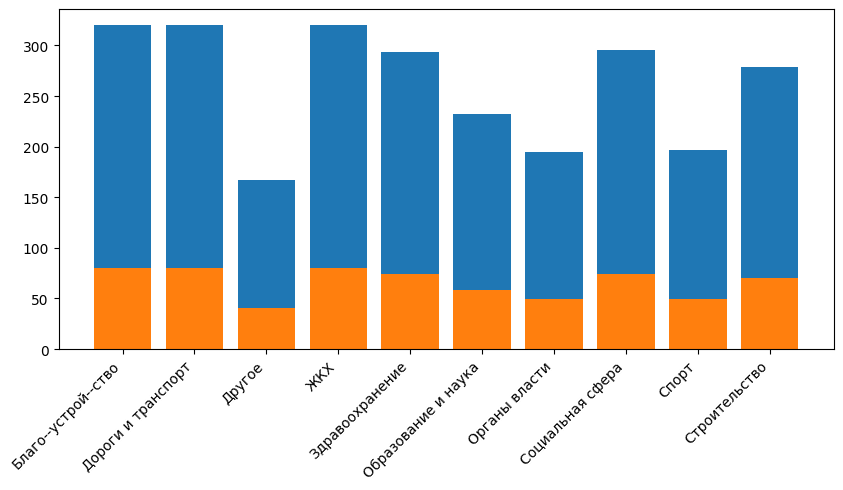

In [31]:
# Проверка сбалансированности выборок по классам
fig = plt.figure(figsize=(10, 5))
c_train = np.bincount(np.argmax(y_train, axis=1))
c_test = np.bincount(np.argmax(y_test, axis=1))
plt.bar(CLASS_LIST, c_train)
plt.bar(CLASS_LIST, c_test)
fig.autofmt_xdate(rotation=45)
plt.show()

### BagOfWords + Dense

Вы почти закончили, осталось поэкспериментировать с обучением прежних моделей НС
на обновленных данных. Теперь модель предсказывает принадлежность обращения
гражданина в пределах десяти категорий. Перед вами архитектура и дальнейшее обучение
модели *BagOfWords + Dense*:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 100)            │     3,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,021,310 (11.53 MB)

 Trainable params: 3,021,310 (11.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.1338 - loss: 2.2800 - val_accuracy: 0.3878 - val_loss: 1.9446
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3921 - loss: 1.8232 - val_accuracy: 0.6214 - val_loss: 1.2768
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6541 - loss: 1.0930 - val_accuracy: 0.6885 - val_loss: 0.9948
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8059 - loss: 0.6365 - val_accuracy: 0.7023 - val_loss: 0.9563
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8824 - loss: 0.4114 - val_accuracy: 0.7191 - val_loss: 1.0013
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9255 - loss: 0.2968 - val_accuracy: 0.7221 - val_loss: 1.0289
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9355 - loss: 0.2325 - val_accuracy: 0.7115 - val_loss: 1.0661
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9613 - loss: 0.1529 - val_accuracy: 0.7282 - val_loss

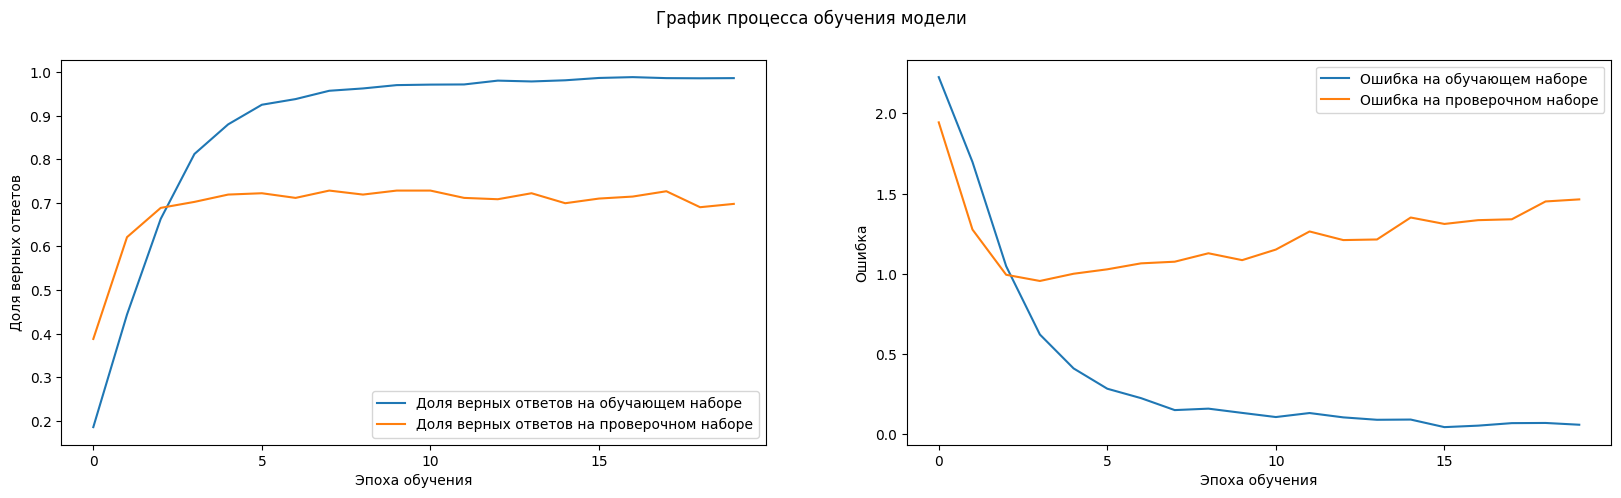

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


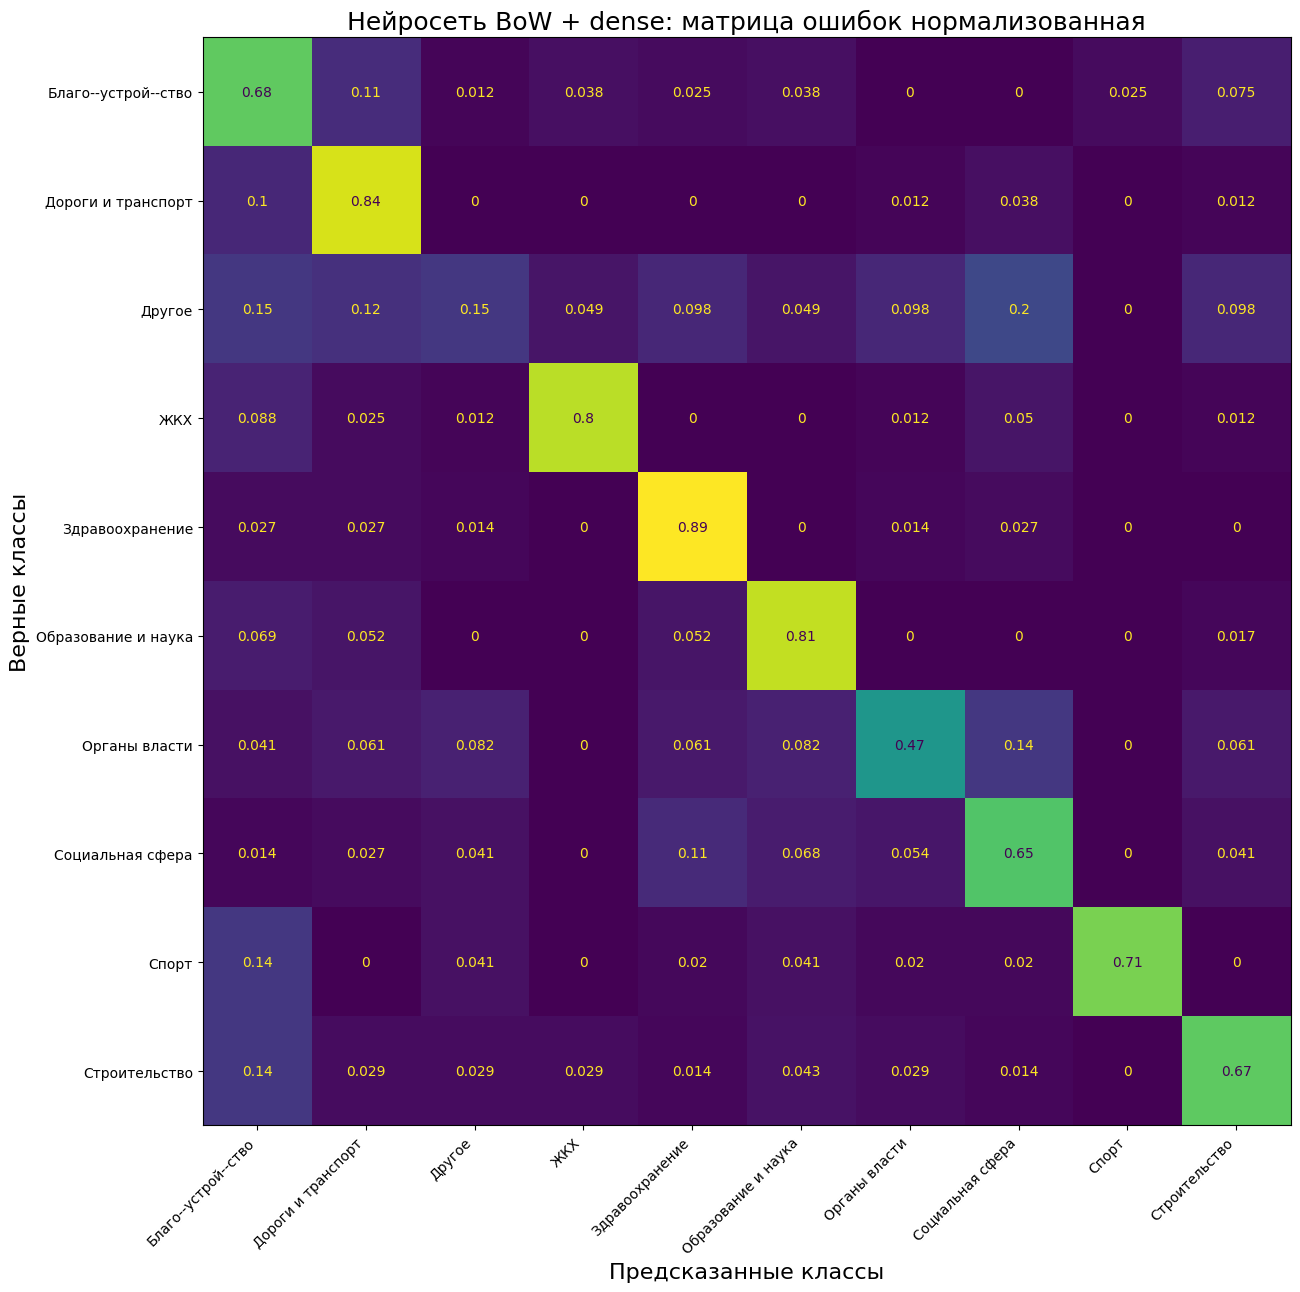

----------------------------------------------------------------------------------------------------
Нейросеть: BoW + dense
Класс: Благо­­устрой­­ство   68% сеть отнесла к классу Благо­­устрой­­ство  - ВЕРНО :-)
Класс: Дороги и транспорт    84% сеть отнесла к классу Дороги и транспорт   - ВЕРНО :-)
Класс: Другое                20% сеть отнесла к классу Социальная сфера     - НЕВЕРНО :-(
Класс: ЖКХ                   80% сеть отнесла к классу ЖКХ                  - ВЕРНО :-)
Класс: Здравоохранение       89% сеть отнесла к классу Здравоохранение      - ВЕРНО :-)
Класс: Образование и наука   81% сеть отнесла к классу Образование и наука  - ВЕРНО :-)
Класс: Органы власти         47% сеть отнесла к классу Органы власти        - ВЕРНО :-)
Класс: Социальная сфера      65% сеть отнесла к классу Социальная сфера     - ВЕРНО :-)
Класс: Спорт                 71% сеть отнесла к классу Спорт                - ВЕРНО :-)
Класс: Строительство         67% сеть отнесла к классу Строительство        - ВЕРН

In [32]:
# Последовательная модель
model_text_bow_dense = Sequential()
# Входной полносвязный слой
model_text_bow_dense.add(Dense(100, input_dim=VOCAB_SIZE, activation="relu"))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Второй полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Третий полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Выходной полносвязный слой
model_text_bow_dense.add(Dense(CLASS_COUNT, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_dense,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         epochs=20,
                         batch_size=32,
                         cm_size=(16, 16),
                         class_labels=CLASS_LIST,
                         title='BoW + dense')

**Выводы по обучению модели BagOfWords + Dense на обновленной базе**

1. И на обучающей, и на проверочной выборках процесс обучения проходил с
положительной тенденцией. Но ошибка сети немного росла на проверочной, что
может говорить о необходимости немного поменять архитектуру НС.
2. График-матрица ошибок показал, что НС довольно хорошо научилась
предсказывать 7 из 10 категорий.
3. Средняя точность работы сети – 69% (оценка «удовлетворительно»), что
значительно выше результата обучения на разбалансированной базе.

### Embedding + Dense

Выполните прежний ряд операций с данными для *Embedding*:

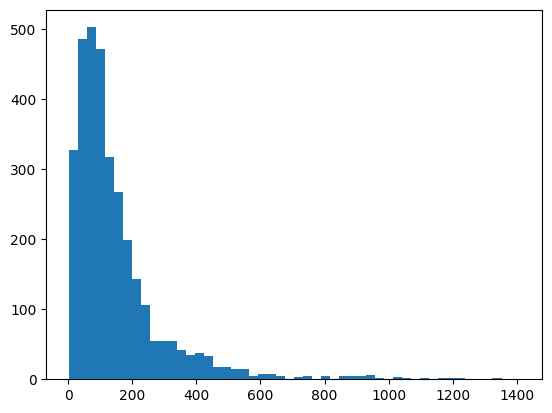

In [33]:
# Построение гистограммы распределения длин текстов в словах основного набора
seq_len = [len(x) for x in x_data]
plt.hist(seq_len, 50)
plt.show()

In [34]:
# Снижение размерности входных данных:
# ограничение длины последовательностей до разумного предела
seq_max_len = 400
x_train_clip = pad_sequences(x_train, maxlen=seq_max_len)
x_test_clip = pad_sequences(x_test, maxlen=seq_max_len)

# Проверка формы результата
print(x_train_clip.shape, x_test_clip.shape)

(2620, 400) (655, 400)


И посмотрите на обучение модели *Embedding + Dense* на обновленной базе:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.1045 - loss: 2.7795 - val_accuracy: 0.1069 - val_loss: 2.3129
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3220 - loss: 1.9452 - val_accuracy: 0.1084 - val_loss: 2.3104
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8164 - loss: 0.7434 - val_accuracy: 0.1740 - val_loss: 2.2474
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9526 - loss: 0.3055 - val_accuracy: 0.1969 - val_loss: 2.2055
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9777 - loss: 0.1583 - val_accuracy: 0.2412 - val_loss: 2.1395
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9932 - loss: 0.0816 - val_accuracy: 0.2336 - val_loss: 2.1017
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9951 - loss: 0.0583 - val_accuracy: 0.2748 - val_loss: 2.0890
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9981 - loss: 0.0390 - val_accuracy: 0.2718 - val_loss

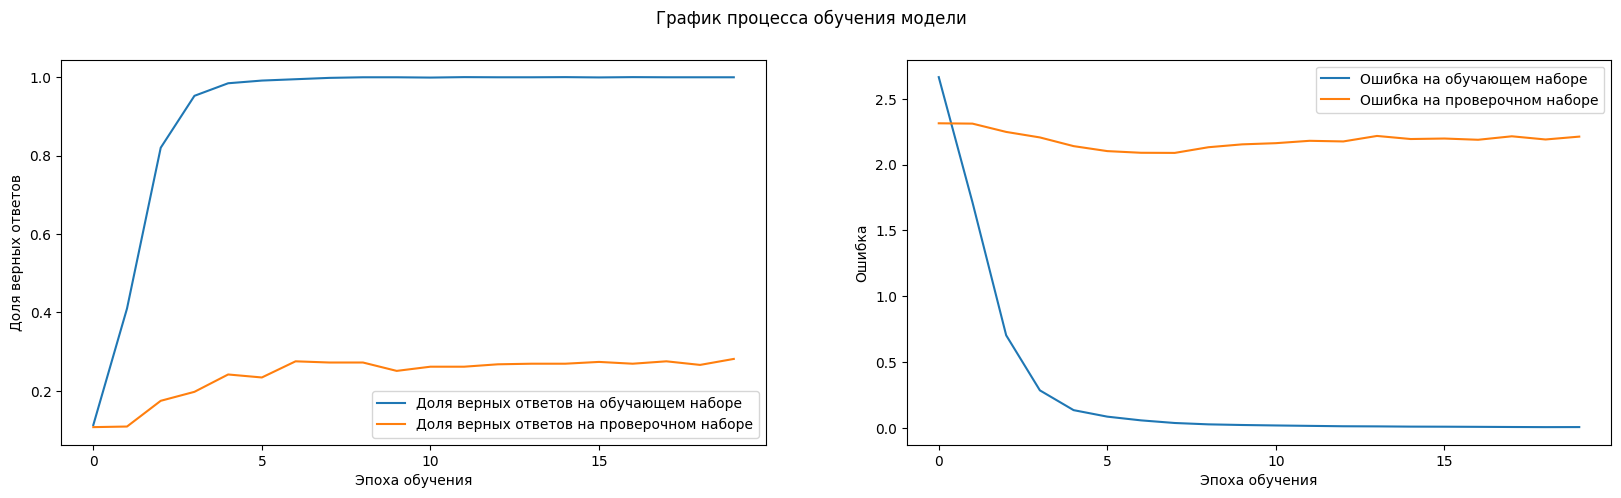

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


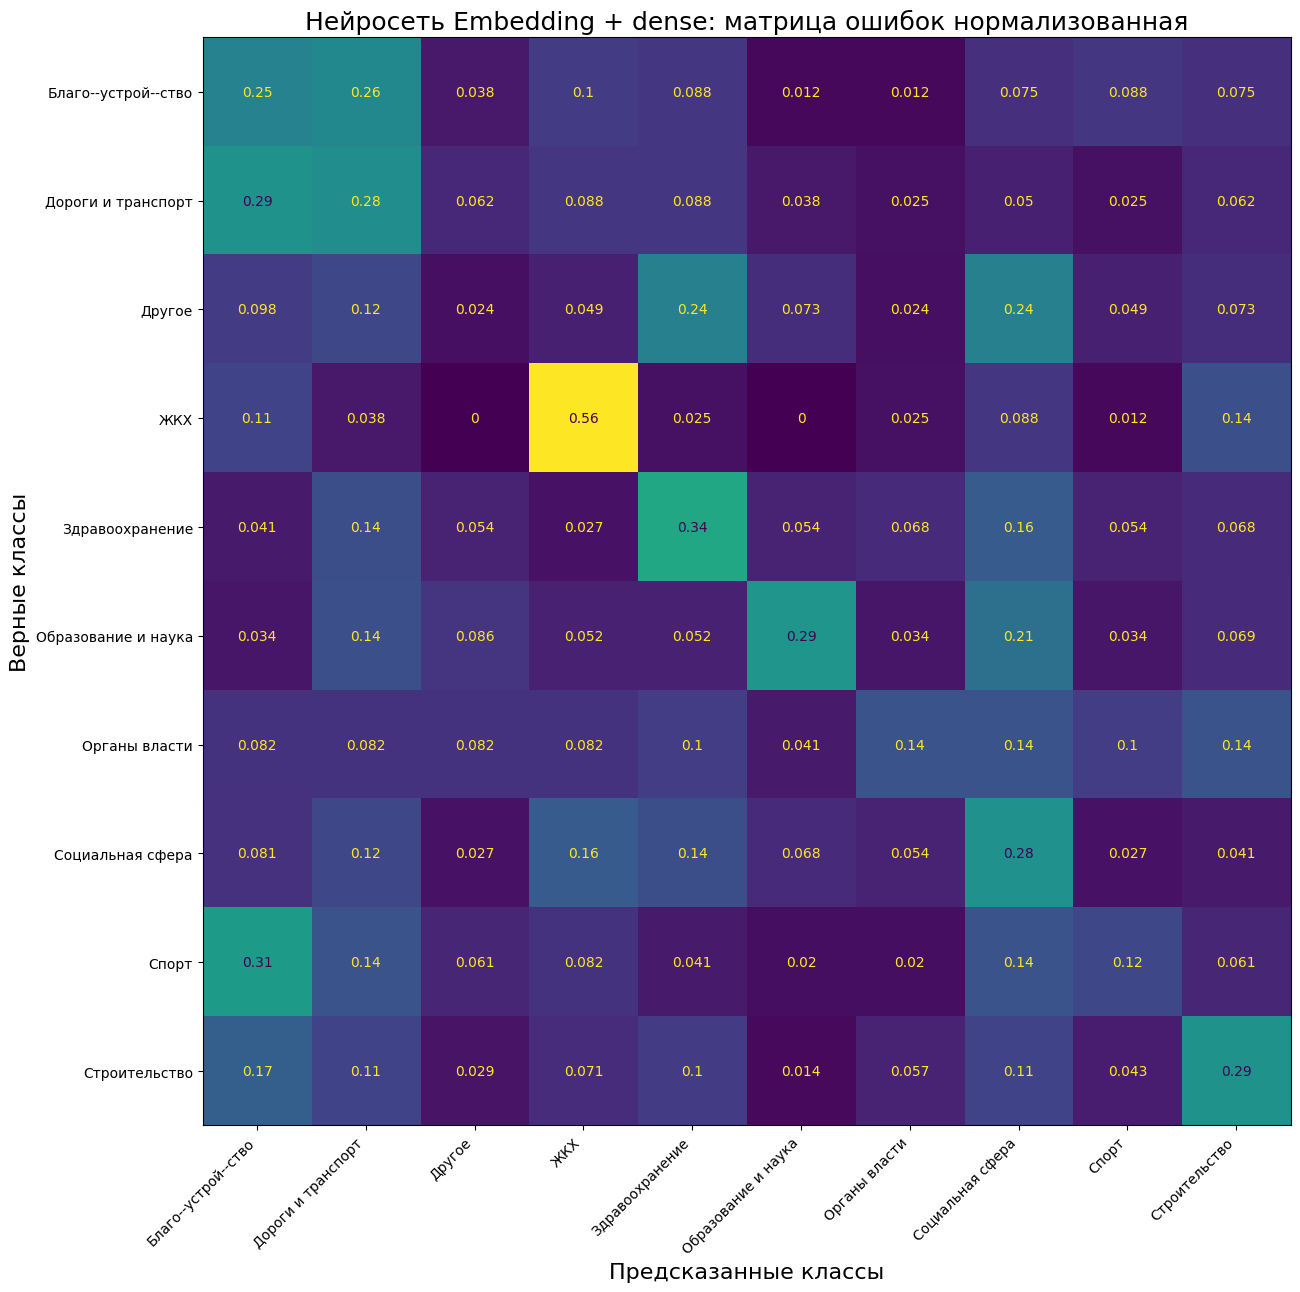

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding + dense
Класс: Благо­­устрой­­ство   26% сеть отнесла к классу Дороги и транспорт   - НЕВЕРНО :-(
Класс: Дороги и транспорт    29% сеть отнесла к классу Благо­­устрой­­ство  - НЕВЕРНО :-(
Класс: Другое                24% сеть отнесла к классу Здравоохранение      - НЕВЕРНО :-(
Класс: ЖКХ                   56% сеть отнесла к классу ЖКХ                  - ВЕРНО :-)
Класс: Здравоохранение       34% сеть отнесла к классу Здравоохранение      - ВЕРНО :-)
Класс: Образование и наука   29% сеть отнесла к классу Образование и наука  - ВЕРНО :-)
Класс: Органы власти         14% сеть отнесла к классу Органы власти        - ВЕРНО :-)
Класс: Социальная сфера      28% сеть отнесла к классу Социальная сфера     - ВЕРНО :-)
Класс: Спорт                 31% сеть отнесла к классу Благо­­устрой­­ство  - НЕВЕРНО :-(
Класс: Строительство         29% сеть отнесла к классу Строительство  

In [35]:
# Последовательная модель
model_text_emb_dense = Sequential()
# Cлой эмбеддингов
model_text_emb_dense.add(Embedding(VOCAB_SIZE, 50, input_length=seq_max_len))
# Слой регуляризации Dropout
model_text_emb_dense.add(SpatialDropout1D(0.2))
# Cлой преобразования многомерных данных в одномерные
model_text_emb_dense.add(Flatten())
# Слой пакетной нормализации
model_text_emb_dense.add(BatchNormalization())
# Полносвязный слой
model_text_emb_dense.add(Dense(64, activation="relu"))
# Слой регуляризации Dropout
model_text_emb_dense.add(Dropout(0.2))
# Слой пакетной нормализации
model_text_emb_dense.add(BatchNormalization())
# Выходной полносвязный слой
model_text_emb_dense.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_text_emb_dense,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         epochs=20,
                         batch_size=32,
                         cm_size=(16, 16),
                         class_labels=CLASS_LIST,
                         title='Embedding + dense')

**Выводы по обучению модели Embedding + Dense на обновленной базе**

1. Точность на обучающей выборке росла, ошибка сети падала. Но проверочный
набор снова сообщил о вялотекущем прогрессе: точность едва ли росла, да и
ошибка не показала тенденции на понижение.
2. График-матрица ошибок продемонстрировал, что НС еле-еле научилась
предсказывать категории «Дороги и транспорт», «Здравоохранение» и «ЖКХ».
3. Средняя точность работы сети составила 31%, что вдвое выше точности той же
модели в первом эксперименте. Но это все равно плохой результат (оценка
«неудовлетворительно»).

### Итоги экспериментов

В обработке базы обращений граждан наилучший результат показала полносвязная сеть
*Bag Of Words*. Но не стоит недооценивать *Embedding*: использование данного слоя в НС
просто не подошло под конкретный тип задачи. Есть ряд задач, где *Embedding*, напротив,
справится лучше, чем *Bag Of Words*. Учитывайте, какую большую роль играет качество
базы данных в обучении: после фильтрации и балансировки исходной базы вы увеличили
точность работы НС более, чем в 2 раза.

> Важно: предложенный в данном блокноте способ выравнивания
(балансировки) данных – не единственный и не самый лучший.
Разработано довольно много способов балансировки данных, включая
аугментацию. Выбирайте наиболее подходящий способ, исходя из
природы, объема данных, а также из конкретной прикладной задачи.

На этом сегодняшние эксперименты подошли к концу. До новых встреч!

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1vpNRvLYFs9NddIiuMl3-HIpUBeOj8Up5?usp=sharing)

2. [Практический ноутбук 1](https://colab.research.google.com/drive/1fl5Cyd8Vf105Yqxvbq2_Z7cILyU4xl1r?usp=sharing)

3. Практический ноутбук 2
